# Anexo a Artículo Revista de Marina:
## Eficiencia Computacional vs. Optimalidad en la Asignación de Arma-Blanco para un TEWA.
**Autor: Eduardo Carrasco Vidal**, Oficial de Marina, Dirección de Programas, Investigación y Desarrollo de la Armada.

## A. Weapon–Target Assignment via Piecewise Linearization and CPLEX
> Este notebook muestra paso a paso cómo resolver el modelo WTA (Ecuación canónica de Maine, 1958) mediante una linearización por tramos (Piecewise Linear, PWL), de modo que pueda ser resuelto en solvers estándar como CPLEX, los cuales no permiten funciones no lineales.

> ### 1. Modelo canónico

> **Variables de decisión**  
- $x_{ij}\in\mathbb{Z}_+$: número de armas de tipo $i$ asignadas al blanco $j$.

> **Parámetros**  
- $w_i$: inventario disponible de armas tipo $i$.  
- $V_j$: valor de destrucción del blanco $j$.  
- $p_{ij}$: probabilidad de impacto de un arma tipo $i$ sobre el blanco $j$.  
- Se define $q_{ij} = 1 - p_{ij}$ como la probabilidad de supervivencia del blanco $j$ frente a un arma tipo $i$.

> **Función objetivo**  
Minimizar la supervivencias esperada (total):  
El blanco $j$ sobrevive a un ataque si todas las armas asignadas fallan. 
> La probabilidad total de supervivencia del blanco $j$ es:
  $$
    \prod_{i=1}^m q_{ij}^{x_{ij}}
   $$
> Multiplicado por el valor $V_j$ del blanco, la función objetivo se expresa como:
  $$
    \min_{x\in\mathbb{Z}_+}\;F(x)
    \;=\;
    \sum_{j=1}^n V_j \,\prod_{i=1}^m (1 - p_{ij})^{\,x_{ij}}
    \;=\;
    \sum_{j=1}^n V_j \,\prod_{i=1}^m (q_{ij})^{\,x_{ij}}
  $$
> Utilizando la propiedad de los logaritmos: 
  $$
    \prod (a_{i})
    \;=\;
    \exp\!\Bigl(\sum \ln a_{i}\Bigr)
  $$
> Entonces:
  $$
    \prod_{i=1}^m q_{ij}^{x_{ij}} = \exp\left( \sum_{i=1}^m x_{ij} \cdot \ln q_{ij} \right)
  $$

> Reescribimos la **función objetivo** como:
  $$
    \min_{x\in\mathbb{Z}_+}\;F(x)
    \;=\;
    \sum_{j=1}^n V_j \exp\!\Bigl(\sum_{i=1}^m x_{ij}\ln q_{ij}\Bigr).
  $$

> **Restricciones**  
(1) Inventario de armas:
  $$
    \sum_{j=1}^n x_{ij} \;\le\; w_i
    \quad
    \forall\,i=1,\dots,m
  $$
> (2) Dominio entero:
  $$
    x_{ij}\in\mathbb{Z}_+,
    \quad
    \forall\,i=1,\dots,m,\;j=1,\dots,n.
  $$
---
> ### 2. Linealización _Piecewise Linear_ (PWL)
Como la función exponencial no puede ser manipulada por CPLEX, se procede a una linealización por tramos.

> #### 2.1. Introducción de variable auxiliar
> Definimos una variable auxiliar para cada blanco $j$:
  $$
    y_j = \sum_{i=1}^m x_{ij} \cdot \ln q_{ij}
  $$
> Entonces, la contribución del blanco $j$ a la función objetivo se puede escribir como:
  $$
    f_j = V_j \cdot e^{y_j}
  $$

> #### 2.2. Acotación del dominio de $( y_j )$
> Para poder aplicar una interpolación lineal, necesitamos determinar el intervalo de valores posibles que puede tomar $y_j$.
> - **Upper Bound:** Como $x_{ij} \in [0, w_i]$ y $\ln q_{ij} < 0$, el valor máximo de $y_j$ ocurre cuando no se asignan armas:
  $$
    \overline y_j = 0
  $$

> - **Lower Bound:** El valor mínimo ocurre cuando se asignan todas las armas disponibles de cada tipo:
  $$
    \underline y_j = \sum_{i=1}^m w_i \cdot \ln q_{ij}
  $$
> Este intervalo $([\underline y_j, \overline y_j])$ es el dominio sobre el que se realizará la interpolación.

> #### 2.3. Discretización: puntos de ruptura
> Dividimos el intervalo $([\underline y_j, \overline y_j])$ en $K$ segmentos iguales. Para cada punto $k = 0, 1, \dots, K$ definimos:

> - Coordenadas del eje y: 
  $$
    \xi_{j,k} = \underline y_j + \frac{k}{K} (\overline y_j - \underline y_j)
  $$

> - Evaluación de la función en cada punto:
  $$
    f_{j,k} = V_j \cdot e^{\xi_{j,k}}
  $$
> Estos son los valores exactos de la función en los puntos que usaremos para la interpolación.

> #### 2.4. Interpolación lineal mediante variables $(\lambda_{j,k})$
> Introducimos variables auxiliares $\lambda_{j,k} \ge 0$ que representan el peso de cada punto de ruptura en la combinación convexa.
> Estas variables deben cumplir las siguientes condiciones:

> - (1) Combinación convexa:  
  $$
    \sum_{k=0}^K \lambda_{j,k} = 1
  $$

> - (2) Interpolación del valor de $y_j$:
  $$
    y_j = \sum_{k=0}^K \xi_{j,k} \cdot \lambda_{j,k}
  $$

> - (3) Interpolación del valor de $f_j$:
  $$
    f_j = \sum_{k=0}^K f_{j,k} \cdot \lambda_{j,k}
  $$
> Como $\exp(y)$ es una función convexa, esta aproximación subestima ligeramente el valor real. La precisión mejora aumentando el número de segmentos $K$.
---
> ### 3. Modelo final (linealizado)

> **Variables:**
- $x_{ij} \in \mathbb{Z}_+$
- $y_j \in \mathbb{R}$
- $\lambda_{j,k} \in [0,1]$

>**Función objetivo final:**
  $$
    \min \sum_{j=1}^n f_j = \sum_{j=1}^n \sum_{k=0}^K f_{j,k} \cdot \lambda_{j,k}
  $$
**Sujeto a:**
> (3.1) Restricción de inventario
  $$
    \sum_{j=1}^n x_{ij} \le w_i
    \quad \forall\,i 
  $$
> (3.2) Definición exacta de $y_j$
  $$
    y_j = \sum_{i=1}^m x_{ij} \cdot \ln q_{ij}
  $$
> (3.3) Interpolación de valor de $f_j$
  $$
    f_j = \sum_{k=0}^K f_{j,k} \cdot \lambda_{j,k}
  $$
> (3.4) Interpolación de valor de $y_j$
  $$
    y_j = \sum_{k=0}^K \xi_{j,k} \cdot \lambda_{j,k}
  $$
> (3.5) Combinación convexa
  $$
    \sum_{k=0}^K \lambda_{j,k} = 1, \quad \lambda_{j,k} \ge 0
  $$
---

In [ ]:
import math
import random
import time
import pandas as pd
import pulp

def solve_wta_pwl(
    w,         # lista de inventarios w[i] para cada tipo i
    n,         # número de blancos
    K,         # número de tramos PWL
    seed=218   # n° de cadete de la suerte
):
    random.seed(seed)
    m = len(w)

    # 1) Generar aleatoriamente p_{ij}∈[0.5,0.8] y V_j∈[5,10]
    p = [[random.uniform(0.5, 0.8) for j in range(n)] for i in range(m)]
    V = [random.uniform(5, 10)   for j in range(n)]

    # 2) Pre-cálculos
    q     = [[1 - p[i][j] for j in range(n)] for i in range(m)]
    y_min = [sum(w[i]*math.log(q[i][j]) for i in range(m)) for j in range(n)]
    breaks = {
        j: [y_min[j] + k*(0.0 - y_min[j])/K for k in range(K+1)]
        for j in range(n)
    }
    f_vals = {
        j: [V[j]*math.exp(y) for y in breaks[j]]
        for j in range(n)
    }

    # 3) Construir el modelo PWL en PuLP
    model = pulp.LpProblem("WTA_PWL", pulp.LpMinimize)

    # Variables
    x   = pulp.LpVariable.dicts("x",   (range(m), range(n)), lowBound=0, cat="Integer")
    y   = { j: pulp.LpVariable(f"y_{j}", lowBound=y_min[j], upBound=0.0)
            for j in range(n) }
    f_j = { j: pulp.LpVariable(f"f_{j}", lowBound=min(f_vals[j]), upBound=max(f_vals[j]))
            for j in range(n) }
    lam = { (j,k): pulp.LpVariable(f"lam_{j}_{k}", lowBound=0)
            for j in range(n) for k in range(K+1) }

    # 4) Restricciones PWL + enlace
    for j in range(n):
        model += pulp.lpSum(lam[(j,k)] for k in range(K+1)) == 1 # Combinación convexa (3.5)
        model += y[j]   == pulp.lpSum(breaks[j][k]  * lam[(j,k)] for k in range(K+1)) # Interpolación de y_j (3.4)
        model += f_j[j] == pulp.lpSum(f_vals[j][k] * lam[(j,k)] for k in range(K+1)) # Interpolación de f_j (3.3)
        model += y[j]   == pulp.lpSum(x[i][j] * math.log(q[i][j]) for i in range(m)) # Definición exacta de y_j (3.2)

    # 5) Inventario de armas
    for i in range(m):
        model += pulp.lpSum(x[i][j] for j in range(n)) <= w[i] # Restricción de inventario (3.1)

    # 6) Objetivo
    model += pulp.lpSum(f_j[j] for j in range(n)) # Función objetivo final

    # 7) Resolver con CPLEX (ajusta el path si es necesario)
    start = time.time()
    model.solve(pulp.CPLEX_CMD(
        path="/Applications/CPLEX_Studio_Community2211/cplex/bin/arm64_osx/cplex",
        msg=False
    ))
    status = pulp.LpStatus[model.status]
    print(f"Estado del solver: {status}")
    elapsed_exact = time.time() - start

    # 8) Leer solución
    if status != "Optimal":
        raise RuntimeError(f"CPLEX no encontró solución óptima (estado: {status})")
    sol = [[int(round(pulp.value(x[i][j]))) for j in range(n)] for i in range(m)]
    obj = pulp.value(model.objective)

    return sol, obj, p, V, elapsed_exact

# —————————————— MAIN ——————————————
if __name__ == "__main__":
    # Parámetros que puedes cambiar:
    w = [4, 4, 3, 0, 3, 3]   # inventario de armamento de 6 buques
    n = 12                   # cantidad de amenazas (blancos)
    K = 70                   # cantidad de tramos PWL
    sol, obj, p, V, elapsed_exact = solve_wta_pwl(w, n, K, seed=218)

    print(f"Resultados Algoritmo Exacto - CPLEX (PWL)")
    print(f"Objetivo (suma supervivencia de las amenazas): {obj:.4f}")
    print(f"Tiempo de resolución (exacto): {elapsed_exact:.4f} segundos")
    print("Asignación x[i][j]:")
    for i in range(len(w)):
        for j in range(n):
            if sol[i][j]:
                print(f"  Buque {i} →amenaza {j}: {sol[i][j]} misil(es)")

    # Opcional: imprime p y V para referencia
    print("\np_ij (misil→blanco):")
    for row in p: 
        print(" ", ["{:.2f}".format(v) for v in row])
    print("\nV_j (valor de cada blanco):", ["{:.2f}".format(v) for v in V])


Estado del solver: Optimal
Resultados Algoritmo Exacto - CPLEX (PWL)
Objetivo (suma supervivencia de las amenazas): 12.6512
Tiempo de resolución (exacto): 0.1202 segundos
Asignación x[i][j]:
  Buque 0 →amenaza 2: 1 misil(es)
  Buque 0 →amenaza 5: 1 misil(es)
  Buque 0 →amenaza 7: 2 misil(es)
  Buque 1 →amenaza 0: 2 misil(es)
  Buque 1 →amenaza 1: 2 misil(es)
  Buque 2 →amenaza 3: 1 misil(es)
  Buque 2 →amenaza 6: 1 misil(es)
  Buque 2 →amenaza 9: 1 misil(es)
  Buque 4 →amenaza 4: 1 misil(es)
  Buque 4 →amenaza 10: 2 misil(es)
  Buque 5 →amenaza 8: 1 misil(es)
  Buque 5 →amenaza 11: 2 misil(es)

p_ij (misil→blanco):
  ['0.59', '0.53', '0.78', '0.60', '0.56', '0.77', '0.51', '0.72', '0.60', '0.56', '0.60', '0.57']
  ['0.69', '0.75', '0.64', '0.56', '0.57', '0.64', '0.54', '0.72', '0.54', '0.64', '0.68', '0.64']
  ['0.58', '0.77', '0.65', '0.76', '0.55', '0.76', '0.79', '0.58', '0.71', '0.74', '0.78', '0.68']
  ['0.67', '0.73', '0.63', '0.52', '0.55', '0.51', '0.54', '0.69', '0.75', '0.61

## B. Heurística Greedy para el Problema de Asignación Arma–Blanco (WTA)

### 1. Objectivo

Buscamos resolver la formulación canónica del WTA:

$$
\min \sum_{j=1}^{n} V_j \prod_{i=1}^{m} \left(1 - p_{ij} \right)^{x_{ij}}
$$

Donde:

- $ V_j $: Valor de destrucción del blanco $ j $
- $ p_{ij} $: Probabilidad de que el arma $ i $ destruya el blanco $ j $
- $ x_{ij} \in \mathbb{Z}_+ $: Número de armas $ i $ asignadas al blanco $ j $

Esto puede reescribirse utilizando las probabilidades de supervivencia $ q_{ij} = 1 - p_{ij} $:

$$
\min \sum_{j=1}^{n} V_j \prod_{i=1}^{m} q_{ij}^{x_{ij}} = \sum_{j=1}^{n} V_j \cdot \exp\left( \sum_{i=1}^{m} x_{ij} \log q_{ij} \right)
$$

Dado:

$$
y_j = \sum_{i=1}^{m} x_{ij} \log q_{ij}, \quad f_j = V_j \cdot e^{y_j}
$$

Entonces, el objetivo se transforma en:

$$
\min \sum_{j=1}^{n} f_j
$$

---

### 2. Estrategia del Algoritmo Greedy

Utilizamos una heurística greedy simple para aproximar la solución óptima:

1. **Inicializacion**:
   - Fijar todos los $ x_{ij} = 0 $
   - Inicializar el inventario $ w_i $ para cada tipo de arma

2. **Asignar armas iterativamente**:
   - Para cada asignación factible $ (i,j) $, calcular el **incremento marginal en la supervivencia**:
     $
     \Delta f_j = f_j^{\text{new}} - f_j^{\text{current}}
     $
   - Elegir la asignación con el **mínimo** $ \Delta f_j $
   - Actualizar $ x_{ij} $ y disminuir el inventario del arma $ i $

3. **Detener cuando no queden armas** o no haya mejoras posibles.

---

### 3. Output

La salida incluye:

- Objetivo total (suma de valores esperados de supervivencia)
- Matriz de asignación $ x_{ij} $
- Probabilidades $ p_{ij} $ utilizadas
- Valores de los blancos $ V_j $

In [5]:
import math
import random

def solve_wta_greedy(w, n, seed=218):
    random.seed(seed)
    m = len(w)

    # Generar datos aleatorios
    p = [[random.uniform(0.5, 0.8) for j in range(n)] for i in range(m)]
    V = [random.uniform(5, 10) for j in range(n)]

    # Calcular q_{ij}
    q = [[1 - p[i][j] for j in range(n)] for i in range(m)]

    # Inicialización
    x = [[0 for j in range(n)] for i in range(m)]
    remaining = w[:]

    # Estrategia greedy
    start = time.time()
    while True:
        best_delta = float("inf")
        best_i, best_j = None, None

        for i in range(m):
            if remaining[i] == 0:
                continue
            for j in range(n):
                current_yj = sum(x[k][j] * math.log(q[k][j]) for k in range(m))
                current_fj = V[j] * math.exp(current_yj)

                proposed_yj = current_yj + math.log(q[i][j])
                proposed_fj = V[j] * math.exp(proposed_yj)
                delta = proposed_fj - current_fj

                if delta < best_delta:
                    best_delta = delta
                    best_i, best_j = i, j

        if best_i is None:
            break

        x[best_i][best_j] += 1
        remaining[best_i] -= 1

    # Objetivo total
    total_f = 0
    for j in range(n):
        y_j = sum(x[i][j] * math.log(q[i][j]) for i in range(m))
        total_f += V[j] * math.exp(y_j)
    elapsed_greedy = time.time() - start

    # Mostrar resultados
    print(f"Resultados Heurística - (Greedy)")
    print(f"Objetivo (suma supervivencia de las amenazas): {total_f:.4f}")
    print(f"Tiempo de ejecución: {elapsed_greedy:.4f} segundos")
    print("Asignación x[i][j]:")
    for i in range(m):
        for j in range(n):
            if x[i][j] > 0:
                print(f"  Buque {i} →amenaza {j}: {x[i][j]} misil(es)")

    print("\np_ij (misil→blanco):")
    for row in p:
        print(" ", ["{:.2f}".format(v) for v in row])

    print("\nV_j (valor de cada blanco):", ["{:.2f}".format(v) for v in V])

# ——— USO ———
if __name__ == "__main__":
    w = [4, 4, 3, 0, 3, 3]
    n = 12
    solve_wta_greedy(w, n, seed=218)

Resultados Heurística - (Greedy)
Objetivo (suma supervivencia de las amenazas): 13.8762
Tiempo de ejecución: 0.0008 segundos
Asignación x[i][j]:
  Buque 0 →amenaza 2: 1 misil(es)
  Buque 0 →amenaza 5: 1 misil(es)
  Buque 0 →amenaza 7: 1 misil(es)
  Buque 0 →amenaza 11: 1 misil(es)
  Buque 1 →amenaza 0: 1 misil(es)
  Buque 1 →amenaza 1: 1 misil(es)
  Buque 1 →amenaza 9: 2 misil(es)
  Buque 2 →amenaza 1: 1 misil(es)
  Buque 2 →amenaza 6: 1 misil(es)
  Buque 2 →amenaza 10: 1 misil(es)
  Buque 4 →amenaza 3: 1 misil(es)
  Buque 4 →amenaza 4: 1 misil(es)
  Buque 4 →amenaza 10: 1 misil(es)
  Buque 5 →amenaza 7: 1 misil(es)
  Buque 5 →amenaza 8: 1 misil(es)
  Buque 5 →amenaza 11: 1 misil(es)

p_ij (misil→blanco):
  ['0.59', '0.53', '0.78', '0.60', '0.56', '0.77', '0.51', '0.72', '0.60', '0.56', '0.60', '0.57']
  ['0.69', '0.75', '0.64', '0.56', '0.57', '0.64', '0.54', '0.72', '0.54', '0.64', '0.68', '0.64']
  ['0.58', '0.77', '0.65', '0.76', '0.55', '0.76', '0.79', '0.58', '0.71', '0.74', '0.7

## C. Optimality Gap

El **Optimality Gap** es una medida utilizada para evaluar qué tan lejos está una solución heurística (o aproximada) de la solución óptima obtenida por un método exacto. Es especialmente útil cuando se comparan algoritmos como heurísticas (ej. Greedy) frente a modelos exactos resueltos con solvers como CPLEX.

### 1. Fórmula
La brecha de optimalidad se calcula como:

$$
\text{Optimality Gap (\%)} = \frac{Z_{\text{heurístico}} - Z_{\text{óptimo}}}{Z_{\text{óptimo}}} \times 100
$$

Donde:

- $ Z_{\text{óptimo}} $ es el valor de la función objetivo obtenido con el método exacto (benchmark).
- $ Z_{\text{heurístico}} $ es el valor de la función objetivo obtenido con el algoritmo heurístico.

### 2. Interpretación

- **Gap = 0%**: la heurística encontró la solución óptima.
- **Gap > 0%**: la heurística es subóptima; está por encima del óptimo.
- **Gap < 0%**: la heurística supera al modelo exacto (inusual, podría deberse a tolerancia numérica o errores en la formulación del modelo exacto).

In [6]:
import math
import random
import time
import pulp
import pandas as pd

# -----------------------
# GENERADOR DE DATOS
# -----------------------
def generar_datos(m, n, seed=218):
    random.seed(seed)
    p = [[random.uniform(0.5, 0.8) for j in range(n)] for i in range(m)]
    V = [random.uniform(5, 10) for j in range(n)]
    return p, V

# -----------------------
# SOLUCIÓN EXACTA CON PWL
# -----------------------
def solve_wta_pwl(w, p, V, K=70):
    m, n = len(w), len(p[0])
    q = [[1 - p[i][j] for j in range(n)] for i in range(m)]
    y_min = [sum(w[i] * math.log(q[i][j]) for i in range(m)) for j in range(n)]
    breaks = {j: [y_min[j] + k * (0.0 - y_min[j]) / K for k in range(K+1)] for j in range(n)}
    f_vals = {j: [V[j]*math.exp(y) for y in breaks[j]] for j in range(n)}

    model = pulp.LpProblem("WTA_PWL", pulp.LpMinimize)

    x = pulp.LpVariable.dicts("x", (range(m), range(n)), lowBound=0, cat="Integer")
    y = {j: pulp.LpVariable(f"y_{j}", lowBound=y_min[j], upBound=0.0) for j in range(n)}
    f_j = {j: pulp.LpVariable(f"f_{j}", lowBound=min(f_vals[j]), upBound=max(f_vals[j])) for j in range(n)}
    lam = {(j,k): pulp.LpVariable(f"lam_{j}_{k}", lowBound=0) for j in range(n) for k in range(K+1)}

    for j in range(n):
        model += pulp.lpSum(lam[(j,k)] for k in range(K+1)) == 1
        model += y[j] == pulp.lpSum(breaks[j][k] * lam[(j,k)] for k in range(K+1))
        model += f_j[j] == pulp.lpSum(f_vals[j][k] * lam[(j,k)] for k in range(K+1))
        model += y[j] == pulp.lpSum(x[i][j] * math.log(q[i][j]) for i in range(m))

    for i in range(m):
        model += pulp.lpSum(x[i][j] for j in range(n)) <= w[i]

    model += pulp.lpSum(f_j[j] for j in range(n))

    start = time.time()
    model.solve(pulp.CPLEX_CMD(path="/Applications/CPLEX_Studio_Community2211/cplex/bin/arm64_osx/cplex", msg=False))
    elapsed = time.time() - start

    sol = [[int(round(pulp.value(x[i][j]))) for j in range(n)] for i in range(m)]
    obj = pulp.value(model.objective)
    return sol, obj, elapsed

# -----------------------
# SOLUCIÓN GREEDY
# -----------------------
def solve_wta_greedy(w, p, V):
    m, n = len(w), len(p[0])
    q = [[1 - p[i][j] for j in range(n)] for i in range(m)]
    x = [[0 for j in range(n)] for i in range(m)]
    remaining = w[:]
    start = time.time()

    while True:
        best_delta = float("inf")
        best_i, best_j = None, None

        for i in range(m):
            if remaining[i] == 0:
                continue
            for j in range(n):
                current_yj = sum(x[k][j] * math.log(q[k][j]) for k in range(m))
                current_fj = V[j] * math.exp(current_yj)
                proposed_yj = current_yj + math.log(q[i][j])
                proposed_fj = V[j] * math.exp(proposed_yj)
                delta = proposed_fj - current_fj

                if delta < best_delta:
                    best_delta = delta
                    best_i, best_j = i, j

        if best_i is None:
            break
        x[best_i][best_j] += 1
        remaining[best_i] -= 1

    total_f = sum(V[j] * math.exp(sum(x[i][j] * math.log(q[i][j]) for i in range(m))) for j in range(n))
    elapsed = time.time() - start
    return x, total_f, elapsed

# -----------------------
# COMPARACIÓN DE MÉTODOS
# -----------------------
w = [4, 4, 3, 0, 3, 3]
n = 12
p, V = generar_datos(len(w), n, seed=218)

sol_pwl, obj_pwl, t_pwl = solve_wta_pwl(w, p, V)
sol_greedy, obj_greedy, t_greedy = solve_wta_greedy(w, p, V)

gap = 100 * (obj_greedy - obj_pwl) / obj_pwl

# Resultados organizados
resultados = {
    "Método": ["Exacto (PWL)", "Greedy"],
    "Valor objetivo": [obj_pwl, obj_greedy],
    "Tiempo (seg)": [t_pwl, t_greedy],
    "Optimality Gap (%)": [0, gap]
}
df_resultados = pd.DataFrame(resultados)

df_resultados

,Método,Valor objetivo,Tiempo (seg),Optimality Gap (%)
0,Exacto (PWL),12.651231,0.098126,0.000000
1,Greedy,13.876191,0.000531,9.682533


## D. Asignación gráfica de ambos métodos:
Se presenta un mapa de calor que muestra la diferencia entre los resultados obtenidos por el método exacto y el método greedy, rsspecto de la tabla de asignación.

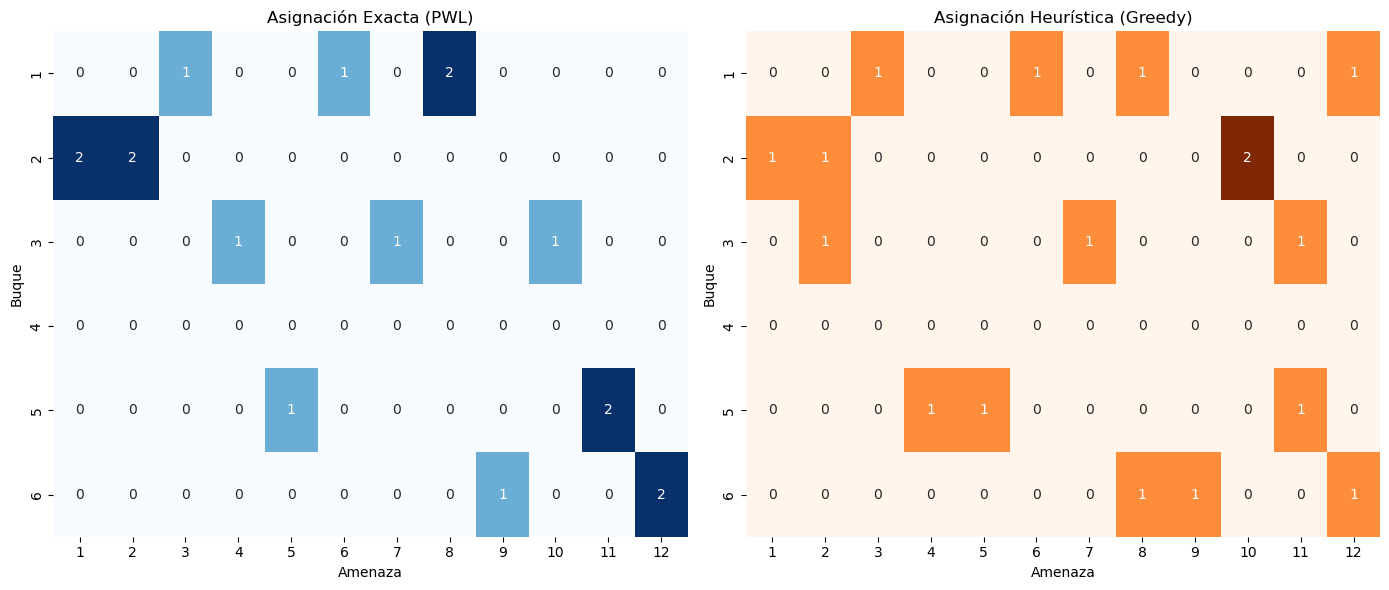

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Crear matrices de asignación
m = 6   # número de buques
n = 12  # número de amenazas

assign_exact = np.zeros((m, n))
assign_greedy = np.zeros((m, n))

# Rellenar matriz exacta
assign_exact[0][2] = 1
assign_exact[0][5] = 1
assign_exact[0][7] = 2
assign_exact[1][0] = 2
assign_exact[1][1] = 2
assign_exact[2][3] = 1
assign_exact[2][6] = 1
assign_exact[2][9] = 1
assign_exact[4][4] = 1
assign_exact[4][10] = 2
assign_exact[5][8] = 1
assign_exact[5][11] = 2

# Rellenar matriz greedy
assign_greedy[0][2] = 1
assign_greedy[0][5] = 1
assign_greedy[0][7] = 1
assign_greedy[0][11] = 1
assign_greedy[1][0] = 1
assign_greedy[1][1] = 1
assign_greedy[1][9] = 2
assign_greedy[2][1] = 1
assign_greedy[2][6] = 1
assign_greedy[2][10] = 1
assign_greedy[4][3] = 1
assign_greedy[4][4] = 1
assign_greedy[4][10] = 1
assign_greedy[5][7] = 1
assign_greedy[5][8] = 1
assign_greedy[5][11] = 1

# Graficar ambos heatmaps
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Exacto
sns.heatmap(assign_exact, annot=True, fmt=".0f", cmap="Blues", ax=axs[0], cbar=False)
axs[0].set_title("Asignación Exacta (PWL)")
axs[0].set_xlabel("Amenaza")
axs[0].set_ylabel("Buque")
axs[0].set_xticks(np.arange(n) + 0.5)
axs[0].set_xticklabels([f"{j+1}" for j in range(n)])
axs[0].set_yticks(np.arange(m) + 0.5)
axs[0].set_yticklabels([f"{i+1}" for i in range(m)])

# Greedy
sns.heatmap(assign_greedy, annot=True, fmt=".0f", cmap="Oranges", ax=axs[1], cbar=False)
axs[1].set_title("Asignación Heurística (Greedy)")
axs[1].set_xlabel("Amenaza")
axs[1].set_ylabel("Buque")
axs[1].set_xticks(np.arange(n) + 0.5)
axs[1].set_xticklabels([f"{j+1}" for j in range(n)])
axs[1].set_yticks(np.arange(m) + 0.5)
axs[1].set_yticklabels([f"{i+1}" for i in range(m)])

plt.tight_layout()

# Guardar con alta resolución (600 dpi para revista)
#plt.savefig("asignacion_comparativa.png", dpi=600, bbox_inches='tight')

plt.show()
